In [1]:
import pyhf
import json
import copy
import jsonpatch
import numpy as np
import matplotlib.pyplot as plt

## Download the Model

In [2]:
# !curl -sL https://doi.org/10.17182/hepdata.89408.v1/r2  | tar -O -xzv RegionA/BkgOnly.json > lhood.json
# !curl -sL https://doi.org/10.17182/hepdata.89408.v1/r2  | tar -O -xzv RegionA/patch.sbottom_750_745_60.json > patch.json

In [3]:
# spec = json.load(open("lhood.json"))
# patch = json.load(open("patch.json"))

In [4]:
test_spec = json.load(open("test.json"))
test_spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [1.0, 1.0],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None}]},
    {'name': 'bkg1',
     'data': [2.0, 8.0],
     'modifiers': [{'name': 'Modelling',
       'type': 'histosys',
       'data': {'hi_data': [5, 12], 'lo_data': [1, 6]}}]},
    {'name': 'bkg2',
     'data': [2.0, 19.0],
     'modifiers': [{'name': 'JES',
       'type': 'histosys',
       'data': {'hi_data': [4, 15], 'lo_data': [1, 8]}},
      {'name': 'JER',
       'type': 'histosys',
       'data': {'hi_data': [2, 15], 'lo_data': [1, 8]}}]},
    {'name': 'bkg3',
     'data': [1.0, 10.0],
     'modifiers': [{'name': 'JES2',
       'type': 'histosys',
       'data': {'hi_data': [4, 15], 'lo_data': [0.5, 14]}},
      {'name': 'JER2',
       'type': 'histosys',
       'data': {'hi_data': [2, 15], 'lo_data': [0.7, 18]}}]}]}],
 'observations': [{'name': 'singlechannel', 'data': [5.0, 28.0]}],
 'measurements': [{'name': 'M

## Code Setup

### Helper Functions

In [5]:
def make_model(spec, channel_list, measurement_name, patch=None):
    if patch is not None:
        spec = jsonpatch.apply_patch(spec, patch)
    spec["channels"] = [
        chan for chan in spec["channels"] if chan["name"] in channel_list
    ]

    ws = pyhf.Workspace(spec)
    model = ws.model(
        measurement_name=measurement_name,
        modifier_settings={
            "normsys": {"interpcode": "code4"},
            "histosys": {"interpcode": "code4p"},
        },
    )
    data = ws.data(model)
    return ws, model, data

In [6]:
def fit_results(model, data, init_pars=None, constraints=None, verbose=False):
    pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=verbose))
    result = pyhf.infer.mle.fit(
        data, model, init_pars, fixed_vals=constraints, return_uncertainties=True
    )
    best_fit = result[:, 0]
    uncerts = result[:, 1]
    #     return model, data, best_fit, uncerts
    return best_fit, uncerts

### Impact Calculator Functions

In [7]:
# def calc_impact(idx, best_fit, uncerts, i, width, poi_index):
def calc_impact(model, data, idx, best_fit, uncerts, init_pars, width):
    poi_index = model.config.poi_index

    down_post_fit, _ = fit_results(
        model, data, init_pars, constraints=[(idx, best_fit - uncerts)]
    )
    poi_down_post = down_post_fit[poi_index]

    up_post_fit, _ = fit_results(
        model, data, init_pars, constraints=[(idx, best_fit + uncerts)]
    )
    poi_up_post = up_post_fit[poi_index]

    down_pre_fit, _ = fit_results(
        model, data, init_pars, constraints=[(idx, best_fit - width)]
    )
    poi_down_pre = down_pre_fit[poi_index]

    up_pre_fit, _ = fit_results(
        model, data, init_pars, constraints=[(idx, best_fit + width)]
    )
    poi_up_pre = up_pre_fit[poi_index]

    return np.asarray([poi_down_post, poi_up_post, poi_down_pre, poi_up_pre])

BUG: There's a bug in the way that `init_pars` is being implimented here are the moment. In the old notebook it exists the same as here, but it was never actually used in the fits. It was passed in but never actually used anywhere. Now when trying to pass it in and use it things break.

In [8]:
def get_impact_data(model, data):
    #     model, _, best_fit, uncerts = fit_results(model, data)
    best_fit, uncerts = fit_results(model, data)
    widths = pyhf.tensorlib.concatenate(
        [
            model.config.param_set(k).width()
            for k, v in model.config.par_map.items()
            if model.config.param_set(k).constrained
        ]
    )
    # BUG: init_pars are not being used correctly in fit and are erroring through MINUIT
    init_pars = pyhf.tensorlib.concatenate(
        [
            model.config.param_set(k).suggested_init
            for k, v in model.config.par_map.items()
            if model.config.param_set(k).constrained
        ]
    )
    # BUG: Turn off for now to not get an error
    init_pars = None
    #     print(f"init_pars: {init_pars}")
    labels = np.asarray(
        [
            "{}[{:02}]".format(k, i)
            if model.config.param_set(k).n_parameters > 1
            else k
            for k in model.config.par_order
            if model.config.param_set(k).constrained
            for i in range(model.config.param_set(k).n_parameters)
        ]
    )
    poi_free = best_fit[model.config.poi_index]
    impacts = []

    # widths do not contain poi_index, so this is safe
    for param_idx, width in enumerate(widths):
        if param_idx > 0 and param_idx % 5 == 0:
            print(f"Impact calculated for {param_idx} nuisance parameters")
        #         impct = calc_impact(i, best_fit[i], uncerts[i], width, init_pars[i], model.config.poi_index) # not being used correctly
        param_impact = calc_impact(
            model,
            data,
            param_idx,
            best_fit[param_idx],
            uncerts[param_idx],
            init_pars,
            width,
        )
        impacts.append(param_impact - poi_free)
    return np.asarray(impacts), labels

## Calculate per-parameter Impact

In [9]:
_, model, data = make_model(test_spec, ["singlechannel"], "Measurement")
impacts, labels = get_impact_data(model, data)

## Make the plot!

In [10]:
def plot_impact(impacts, labels, n_leading=None, xlim=None):
    # Order the nuisance paramters by ascending impact
    impact_order = np.argsort(np.max(np.abs(impacts[:, :2]), axis=1))
    impacts = impacts[impact_order]
    labels = labels[impact_order]

    if n_leading is not None:
        # Leading impact nuisance paramter is last in array
        impacts = impacts[-n_leading:]
        labels = labels[-n_leading:]

    fig, ax = plt.subplots()
    # Postfit -1 sigma impact???
    ax.barh(
        range(len(impacts)),
        np.asarray(impacts)[:, 0],
        alpha=0.75,
        linestyle="dashed",
        facecolor="red",
        label=r"$-1 \sigma$ postfit impact",
    )
    # Postfit +1 sigma impact???
    ax.barh(
        range(len(impacts)),
        np.asarray(impacts)[:, 1],
        alpha=0.75,
        linestyle="dashed",
        facecolor="blue",
        label=r"$+1 \sigma$ postfit impact",
    )
    # Prefit -1 sigma impact????
    ax.barh(
        range(len(impacts)),
        np.asarray(impacts)[:, 2],
        alpha=0.75,
        linestyle="dashed",
        fill=None,
        edgecolor="red",
    )
    # Prefit +1 sigma impact????
    ax.barh(
        range(len(impacts)),
        np.asarray(impacts)[:, 3],
        alpha=0.75,
        linestyle="dashed",
        fill=None,
        edgecolor="blue",
    )
    if xlim is None:
        max_impact = np.max(impacts[-1])
        max_impact = max_impact * 1.05
        xlim = (-max_impact, max_impact)
    ax.set_xlim(xlim)
    ax.set_ylim(-0.5, len(impacts) - 0.5)
    fig.set_size_inches(4, min(1.05 * len(impacts), 17.5))
    ax.set_title("Δµ")
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    ax.grid()

    ax.legend(loc="center left", frameon=False, bbox_to_anchor=(1, 0.5))

    return fig, ax

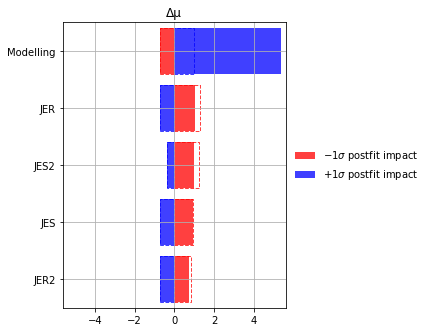

In [11]:
fig, ax = plot_impact(impacts, labels)

Alternative, the $n$ leading impact nuisance parameters can be selected

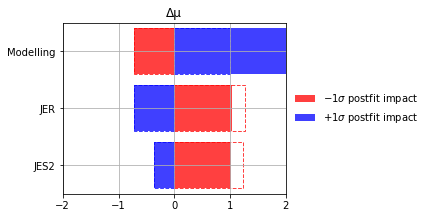

In [12]:
fig, ax = plot_impact(impacts, labels, n_leading=3, xlim=(-2, 2))

In [13]:
spec = json.load(open("lhood.json"))
patch = json.load(open("patch.json"))
_, real_model, real_data = make_model(spec, ["CRtt_meff"], "NormalMeasurement", patch)

# best_fit, uncerts = fit_results(model, data)
# print(model.config.suggested_init())
# calc_impact(model, data, 1, best_fit[1], uncerts[1], model.config.suggested_init(), [1])

# print(model)
# print(data)
# _, model, data = make_model(test_spec, ["singlechannel"], "Measurement")

impacts, labels = get_impact_data(real_model, real_data)

Impact calculated for 5 nuisance parameters
Impact calculated for 10 nuisance parameters
Impact calculated for 15 nuisance parameters
Impact calculated for 20 nuisance parameters
Impact calculated for 25 nuisance parameters
Impact calculated for 30 nuisance parameters
Impact calculated for 35 nuisance parameters
Impact calculated for 40 nuisance parameters
Impact calculated for 45 nuisance parameters
Impact calculated for 50 nuisance parameters
Impact calculated for 55 nuisance parameters


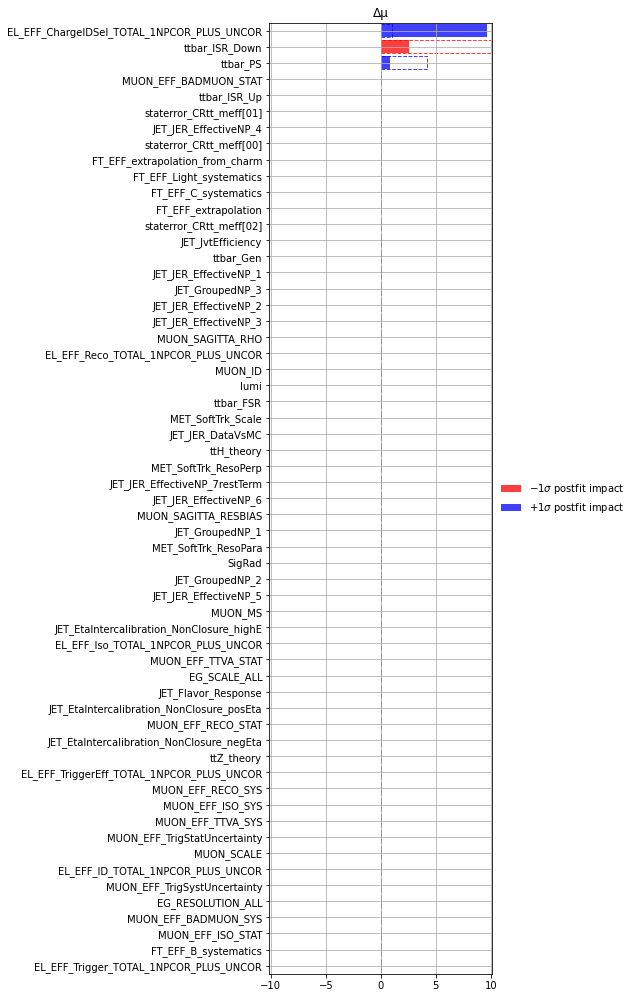

In [14]:
fig, ax = plot_impact(impacts, labels)

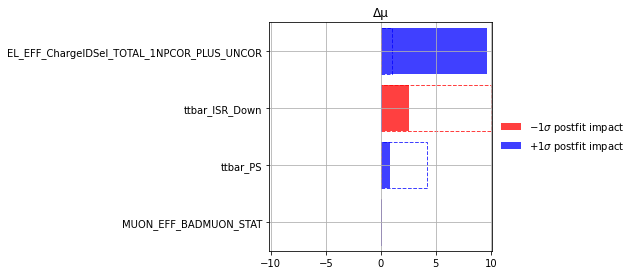

In [15]:
fig, ax = plot_impact(impacts, labels, n_leading=4)